In [1]:
using Base.Threads
using Distributions
using Random
using StatsPlots
default(fmt=:png, titlefontsize=10)

In [2]:
safediv(x, y) = x == 0 ? x : x/y

function pvalue_clopper_pearson(n, k, p)
    k == 0 && return min(1, 2ccdf(Beta(k+1, n-k), p))
    k == n && return min(1, 2cdf(Beta(k, n-k+1), p))
    min(1, 2cdf(Beta(k, n-k+1), p), 2ccdf(Beta(k+1, n-k), p))
end

function pvalue_wilson_score(n, k, p)
    2ccdf(Normal(), safediv(abs(k - n*p), √(n*p*(1-p))))
end

function pvalue_adjusted_wald(n, k, p; z = 2)
    p̂ = (k + z^2/2) / (n + z^2)
    2ccdf(Normal(), safediv(abs(p̂ - p), √(p̂*(1-p̂)/n)))
end

function pvalue_bayesian(n, k, p; a = 1, b = 1)
    min(1, 2cdf(Beta(k+a, n-k+b), p), 2ccdf(Beta(k+a, n-k+b), p))
end

pvalue_bayesian (generic function with 1 method)

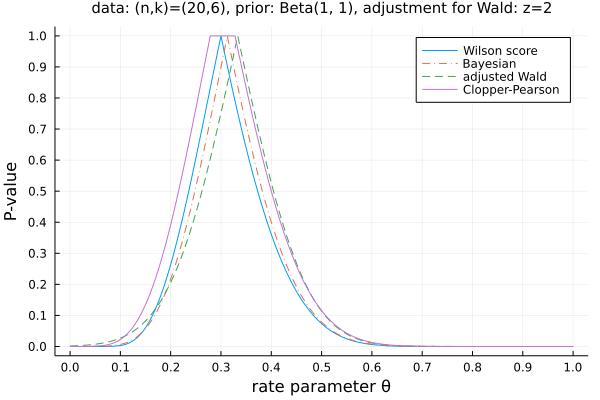

In [3]:
function plot_pvalue_functions(; n = 20, k = 6, z = 2, a = 1, b = 1,
        f = trues(4), kwargs...)
    plot()
    f[1] && plot!(p -> pvalue_wilson_score(n, k, p), 0, 1;
        label="Wilson score", c=1)
    f[2] && plot!(p -> pvalue_bayesian(n, k, p; a, b), 0, 1;
        label="Bayesian", ls=:dashdot, c=2)
    f[3] && plot!(p -> pvalue_adjusted_wald(n, k, p; z), 0, 1;
        label=(z == 0 ? "" : "adjusted ") * "Wald", ls=:dash, c=3)
    f[4] && plot!(p -> pvalue_clopper_pearson(n, k, p), 0, 1;
        label="Clopper-Pearson", c=4)
    plot!(; xtick=0:0.1:1, ytick=0:0.1:1)
    title!("data: (n,k)=($n,$k)" * 
        (f[2] ? ", prior: Beta($a, $b)" : "") *
        (f[3] && z !== 0 ? ", adjustment for Wald: z=$z" : ""))
    plot!(; xguide="rate parameter θ", yguide="P-value")
    plot!(; kwargs...)
end

plot_pvalue_functions(; n = 20, k = 6, z = 2, a = 1, b = 1)

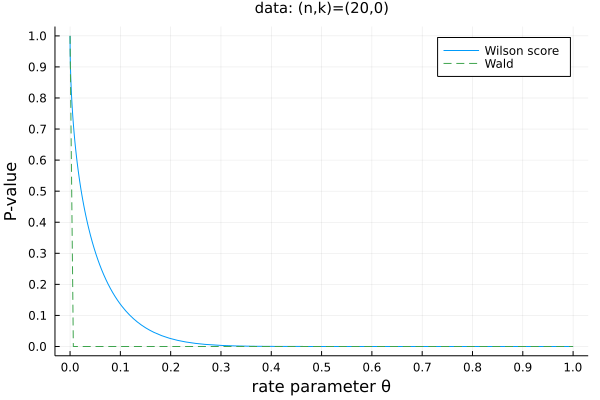

In [4]:
plot_pvalue_functions(; n = 20, k = 0, f = Bool[1,0,1,0], z = 0)

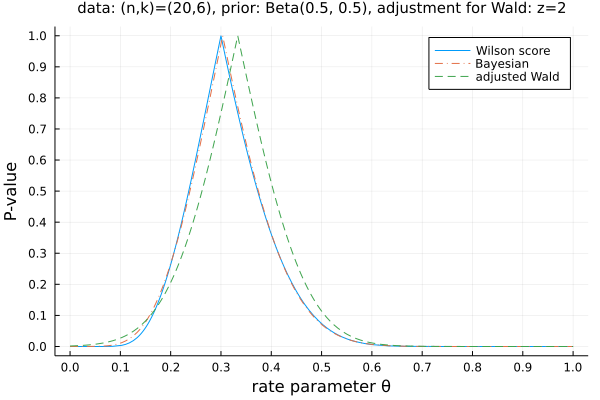

In [5]:
plot_pvalue_functions(; n = 20, k = 6, f = Bool[1,1,1,0], a=0.5, b=0.5)

In [6]:
using Roots
using StatsFuns
using DataFrames

In [7]:
function confint_clopper_pearson(n, k; α = 0.05)
    p_L = k > 0 ? quantile(Beta(k, n-k+1), α/2) : zero(α)
    p_U = k < n ? quantile(Beta(k+1, n-k), 1-α/2) : one(α)
    [p_L, p_U]
end

confint_clopper_pearson (generic function with 1 method)

In [8]:
x ⪅ y = x < y || x ≈ y
_pdf_le(x, (dist, y)) =  pdf(dist, x) ⪅ y

function _search_boundary(f, x0, Δx, param)
    x = x0
    if f(x, param)
        while f(x - Δx, param) x -= Δx end
    else
        x += Δx
        while !f(x, param) x += Δx end
    end
    x
end

function pvalue_sterne(dist::DiscreteUnivariateDistribution, x)
    Px = pdf(dist, x)
    Px == 0 && return Px
    Px == 1 && return Px
    m = mode(dist)
    Px ≈ pdf(dist, m) && return one(Px)
    if x < m
        y = _search_boundary(_pdf_le, 2m - x, 1, (dist, Px))
        cdf(dist, x) + ccdf(dist, y-1)
    else # x > m
        y = _search_boundary(_pdf_le, 2m - x, -1, (dist, Px))
        cdf(dist, y) + ccdf(dist, x-1)
    end
end

function pvalue_sterne(n, k, p)
    pvalue_sterne(Binomial(n, p), k)
end

# 大きな n についてもうまく行くように
# Sterneの信頼区間の実装は難しい.
function confint_sterne(n, k; α = 0.05)
    a, b = confint_clopper_pearson(n, k; α = α/10)
    ps = find_zeros(a-√eps(), b+√eps()) do p
        logistic(0 < p ≤ 1 ? pvalue_sterne(n, k, p) : zero(p)) - logistic(α)
    end
    # 次の行は稀に区間にならない場合への対策
    [first(ps), last(ps)]
end

confint_sterne (generic function with 1 method)

In [9]:
hcat(confint_sterne.(10, 0:10)...)'

11×2 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0        0.290865
 0.0051162  0.446489
 0.0367714  0.553511
 0.0872644  0.619411
 0.150028   0.709135
 0.222441   0.777559
 0.290865   0.849972
 0.380589   0.912736
 0.446489   0.963229
 0.553511   0.994884
 0.709135   1.0

In [10]:
function probabilities_of_type_I_error(; n = 100, z = 2, a = 1, b = 1, α = 0.05, L = 10^6)
    c_clopper_pearson = 0
    c_wilson_score = 0
    c_adjusted_wald = 0
    c_bayesian = 0
    c_sterne = 0
    for i in 1:L
        p = rand()
        k = rand(Binomial(n, p))
        c_clopper_pearson += pvalue_clopper_pearson(n, k, p) < α
        c_wilson_score += pvalue_wilson_score(n, k, p) < α
        c_adjusted_wald += pvalue_adjusted_wald(n, k, p; z) < α
        c_bayesian += pvalue_bayesian(n, k, p; a, b) < α
        c_sterne += pvalue_sterne(n, k, p) < α
    end
    DataFrame(
        method = [
            "Clopper-Pearson",
            "Sterne",
            "adjusted Wald",
            "Wilson score",
            "Bayesian",
        ],
        var"prob. of α-error" = [
            c_clopper_pearson,
            c_sterne,
            c_adjusted_wald,
            c_wilson_score,
            c_bayesian,
        ]/L,
        var"nominal α" = fill(α, 5),
        var"sample size" = fill(n, 5),
   )
end

probabilities_of_type_I_error (generic function with 1 method)

In [11]:
@time probabilities_of_type_I_error(n = 5, α = 0.05)

  1.902471 seconds (1.74 M allocations: 446.526 MiB, 4.19% gc time, 7.50% compilation time)


,method,prob. of α-error,nominal α,sample size
,String,Float64,Float64,Int64
1,Clopper-Pearson,0.009634,0.05,5
2,Sterne,0.019642,0.05,5
3,adjusted Wald,0.004163,0.05,5
4,Wilson score,0.044968,0.05,5
5,Bayesian,0.050045,0.05,5


In [12]:
@time probabilities_of_type_I_error(n = 10, α = 0.05)

  2.083287 seconds (1.87 M allocations: 543.210 MiB, 4.12% gc time)


,method,prob. of α-error,nominal α,sample size
,String,Float64,Float64,Int64
1,Clopper-Pearson,0.016278,0.05,10
2,Sterne,0.026558,0.05,10
3,adjusted Wald,0.012484,0.05,10
4,Wilson score,0.045652,0.05,10
5,Bayesian,0.049899,0.05,10


In [13]:
@time probabilities_of_type_I_error(n = 20, α = 0.05)

  2.352967 seconds (2.37 M allocations: 688.199 MiB, 3.28% gc time)


,method,prob. of α-error,nominal α,sample size
,String,Float64,Float64,Int64
1,Clopper-Pearson,0.022803,0.05,20
2,Sterne,0.033161,0.05,20
3,adjusted Wald,0.022719,0.05,20
4,Wilson score,0.046898,0.05,20
5,Bayesian,0.0499,0.05,20


In [14]:
@time probabilities_of_type_I_error(n = 30, α = 0.05)

  2.438074 seconds (2.61 M allocations: 755.332 MiB, 3.44% gc time)


,method,prob. of α-error,nominal α,sample size
,String,Float64,Float64,Int64
1,Clopper-Pearson,0.026824,0.05,30
2,Sterne,0.037072,0.05,30
3,adjusted Wald,0.028636,0.05,30
4,Wilson score,0.04786,0.05,30
5,Bayesian,0.050232,0.05,30


In [15]:
@time probabilities_of_type_I_error(n = 50, α = 0.05)

  2.373036 seconds (2.83 M allocations: 821.659 MiB, 3.40% gc time)


,method,prob. of α-error,nominal α,sample size
,String,Float64,Float64,Int64
1,Clopper-Pearson,0.030689,0.05,50
2,Sterne,0.039397,0.05,50
3,adjusted Wald,0.034456,0.05,50
4,Wilson score,0.048039,0.05,50
5,Bayesian,0.049805,0.05,50


In [16]:
@time probabilities_of_type_I_error(n = 100, α = 0.05)

  2.555169 seconds (3.07 M allocations: 891.250 MiB, 4.01% gc time)


,method,prob. of α-error,nominal α,sample size
,String,Float64,Float64,Int64
1,Clopper-Pearson,0.035484,0.05,100
2,Sterne,0.042228,0.05,100
3,adjusted Wald,0.040517,0.05,100
4,Wilson score,0.048927,0.05,100
5,Bayesian,0.050047,0.05,100


In [17]:
@time probabilities_of_type_I_error(n = 200, α = 0.05)

  2.695926 seconds (2.62 M allocations: 759.867 MiB, 3.07% gc time)


,method,prob. of α-error,nominal α,sample size
,String,Float64,Float64,Int64
1,Clopper-Pearson,0.039386,0.05,200
2,Sterne,0.044321,0.05,200
3,adjusted Wald,0.04453,0.05,200
4,Wilson score,0.049435,0.05,200
5,Bayesian,0.050195,0.05,200


In [18]:
@time probabilities_of_type_I_error(n = 300, α = 0.05)

  3.502945 seconds (4.43 M allocations: 1.095 GiB, 3.25% gc time)


,method,prob. of α-error,nominal α,sample size
,String,Float64,Float64,Int64
1,Clopper-Pearson,0.040976,0.05,300
2,Sterne,0.045371,0.05,300
3,adjusted Wald,0.045898,0.05,300
4,Wilson score,0.049489,0.05,300
5,Bayesian,0.050043,0.05,300


In [19]:
@time probabilities_of_type_I_error(n = 1000, α = 0.05)

  4.688539 seconds (9.30 M allocations: 2.111 GiB, 4.71% gc time)


,method,prob. of α-error,nominal α,sample size
,String,Float64,Float64,Int64
1,Clopper-Pearson,0.044729,0.05,1000
2,Sterne,0.047327,0.05,1000
3,adjusted Wald,0.048442,0.05,1000
4,Wilson score,0.049806,0.05,1000
5,Bayesian,0.05,0.05,1000
